In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, morphology
from skimage.util import img_as_float
from skimage.filters import frangi
from skimage.morphology import remove_small_objects, binary_closing, disk, skeletonize

In [335]:
def load_images(image_path, mask_path, expert_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    expert = cv2.imread(expert_path, cv2.IMREAD_GRAYSCALE)
    return image, mask, expert


def preprocess_image(image):
    green_channel = image[:, :, 1]
    kernel = np.ones((1, 1), np.uint8)
    dilated = cv2.dilate(green_channel, kernel, iterations=1)
    denoised = cv2.fastNlMeansDenoising(dilated, None, 2, 5, 21)
    equalized = cv2.equalizeHist(denoised)
    # blurred = cv2.GaussianBlur(equalized, (5, 5), 0)
    # sharpened = cv2.addWeighted(equalized, 1.6, blurred, -0.4, 0)
    return green_channel, equalized, equalized


def apply_frangi_filter(image):
    image_float = img_as_float(image)
    vessels = frangi(image_float)
    v_min, v_max = np.percentile(vessels, [5, 95])
    vessels_clipped = np.clip(vessels, v_min, v_max)
    vessels_normalized = (vessels_clipped - v_min) / (v_max - v_min)
    return vessels_normalized


def threshold_vessels(vessels):
    threshold = filters.threshold_otsu(vessels)
    binary_mask = vessels > threshold
    return binary_mask



def postprocess_image(vessels: np.ndarray, mask: np.ndarray) -> np.ndarray:

    # 1. Binarizacja obrazu naczyń
    vessels = np.nan_to_num(vessels)
    binary = vessels > 0.35

    # 2. Czyszczenie i zamykanie morfologiczne
    cleaned = remove_small_objects(binary, min_size=20)
    closed = binary_closing(cleaned, disk(6))
    skeleton = skeletonize(closed)

    # 3. Wymuszone przycięcie do maski FOV
    mask = (mask > 0)
    skeleton = closed & mask  # tylko w obrębie maski

    # 4. Negacja w obrębie maski
    #skeleton[mask] = ~skeleton[mask]  # odwrócenie tylko tam, gdzie maska

    # 5. Konwersja do uint8 (0 i 1)
    return skeleton.astype(np.uint8)



def show_images(images, titles, figsize=(15, 5)):
    plt.figure(figsize=figsize)
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [331]:
image, vessel_mask, expert_mask = load_images(
        "healthy/01_h.jpg",
        "healthy_fovmask/01_h_mask.tif",
         "healthy_manualsegm/01_h.tif"
    )

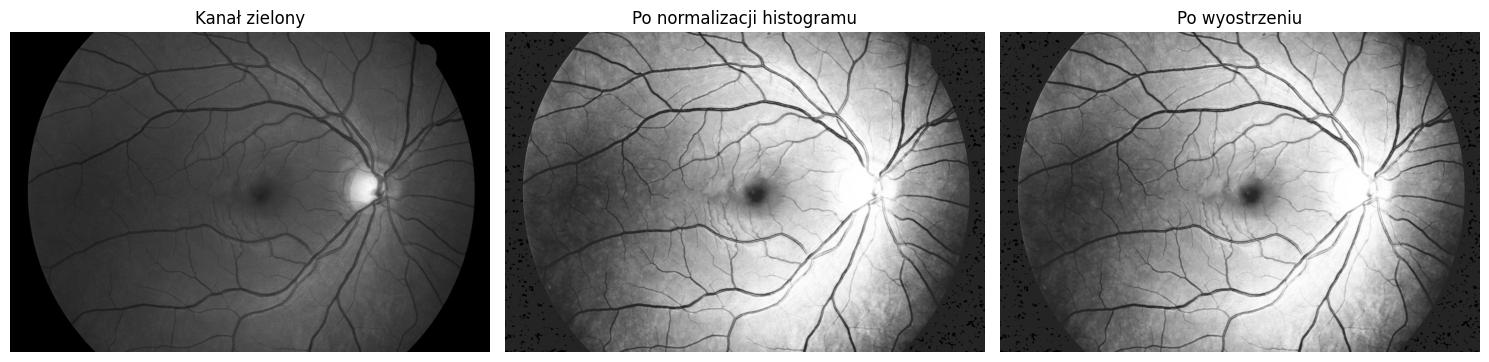

In [325]:
green_channel, equalized, sharpened = preprocess_image(image)

show_images([green_channel, equalized, sharpened], ["Kanał zielony", "Po normalizacji histogramu", "Po wyostrzeniu"])

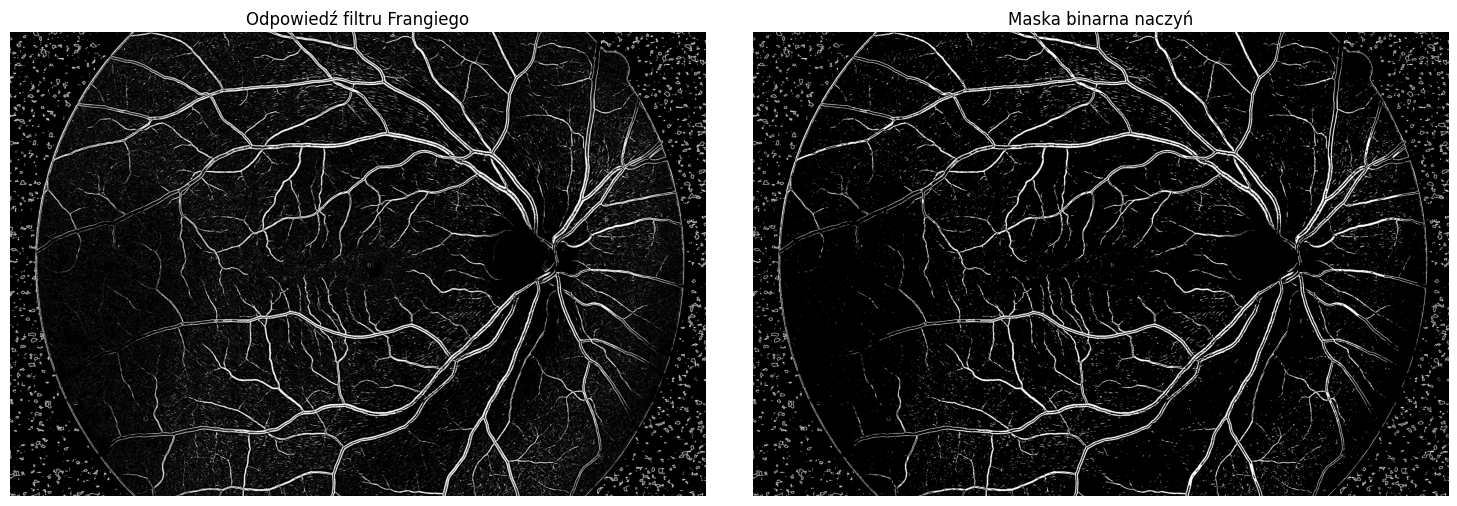

In [326]:
vessels = apply_frangi_filter(sharpened)
vessel_binary = threshold_vessels(vessels)

show_images([vessels, vessel_binary],["Odpowiedź filtru Frangiego", "Maska binarna naczyń"])

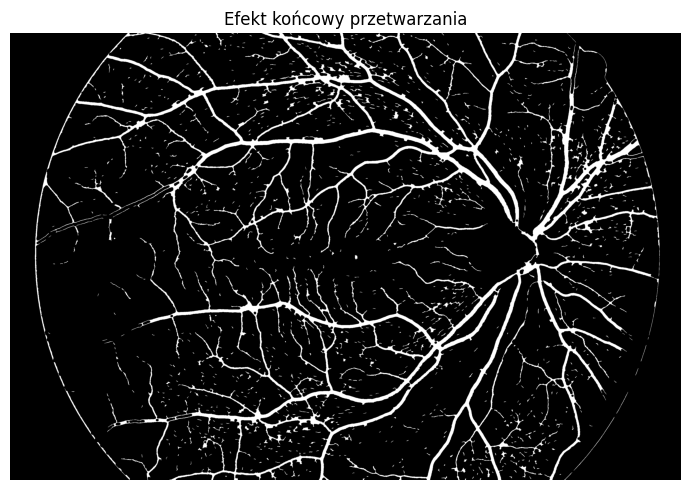

In [336]:
processed = postprocess_image(vessels, vessel_mask)

show_images([processed],['Efekt końcowy przetwarzania'])

 ## Ocena Efektywności

In [148]:
from sklearn.metrics import confusion_matrix
import pandas as pd

def compute_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # recall
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Średnie miary dla niezrównoważonych danych
    harmonic_mean = 2 * (sensitivity * specificity) / (sensitivity + specificity + 1e-6)
    arithmetic_mean = (sensitivity + specificity) / 2

    return {
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'harmonic_mean': harmonic_mean,
        'arithmetic_mean': arithmetic_mean
    }

from skimage.morphology import remove_small_objects, binary_closing, disk
from skimage.filters import frangi
from skimage.util import img_as_float
from skimage import exposure
import numpy as np
import cv2
import pandas as pd

def evaluate_retinal_segmentation(image_paths, mask_paths, fov_masks, min_size=25):
    results = []

    for img_path, msk_path, fov_path in zip(image_paths, mask_paths, fov_masks):
        # obrazy
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV -> RGB
        mask = cv2.imread(msk_path, cv2.IMREAD_GRAYSCALE) > 0
        fov = cv2.imread(fov_path, cv2.IMREAD_GRAYSCALE) > 0

        # Kanał zielony
        green = image[:, :, 1]

        # Dylacja + denoising + equalizacja histogramu
        kernel = np.ones((5, 5), np.uint8)
        dilated = cv2.dilate(green, kernel, iterations=1)
        denoised = cv2.fastNlMeansDenoising(dilated, None, 10, 5, 21)
        enhanced = exposure.equalize_hist(denoised)

        # Filtr Frangiego
        frangi_resp = frangi(enhanced, scale_step=2)
        frangi_norm = (frangi_resp - frangi_resp.min()) / (frangi_resp.max() - frangi_resp.min())

        # Ręczne progowanie (ostatecznie tak wyszlo lepiej)
        binary = (frangi_norm > 0.0001).astype(np.uint8)

        # Finalne progowanie OpenCV 
        binary = (binary * 255).astype(np.uint8)
        _, thresholded = cv2.threshold(binary, 100, 255, cv2.THRESH_BINARY)

        # Postprocessing
        post = remove_small_objects(thresholded.astype(bool), min_size=min_size)
        post = binary_closing(post, footprint=disk(1))
        final_mask = post.astype(np.uint8)

        # Maska FOV – odrzucamy wszystko poza siatkówką
        final_mask[~fov] = 0
        mask[~fov] = 0

        # Konwersja do płaskich wektorów
        y_pred = final_mask[fov].flatten()
        y_true = mask[fov].flatten()

        # Oblicz metryki
        metrics = compute_metrics(y_true, y_pred)
        metrics["image"] = img_path.split("/")[-1]
        results.append(metrics)

        fig, axs = plt.subplots(1, 4, figsize=(20, 5))
        axs[0].imshow(image)
        axs[0].set_title("Obraz źródłowy")

        axs[1].imshow(frangi_norm, cmap='gray')
        axs[1].set_title("Po filtrze Frangiego")

        axs[2].imshow(mask, cmap='gray')
        axs[2].set_title("Maska ekspercka")

        axs[3].imshow(final_mask, cmap='gray')
        axs[3].set_title("Maska przewidziana")

        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

    df = pd.DataFrame(results)
    return df


In [333]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def compute_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    print(tn, fp, fn, tp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    harmonic_mean = 2 * (sensitivity * specificity) / (sensitivity + specificity + 1e-6)
    arithmetic_mean = (sensitivity + specificity) / 2
    return {
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'harmonic_mean': harmonic_mean,
        'arithmetic_mean': arithmetic_mean
    }

def evaluate_retinal_segmentation(image_paths, mask_paths, fov_masks):
    results = []

    for img_path, msk_path, fov_path in zip(image_paths, mask_paths, fov_masks):
        # Wczytanie obrazów
        image, expert_mask, fov_mask = load_images(img_path, msk_path, fov_path)

        # Przetwarzanie
        _, _, sharpened = preprocess_image(image)
        vessels = apply_frangi_filter(sharpened)
        predicted_mask = postprocess_image(vessels, fov_mask)

        # Dopasowanie do masek
        expert_mask = (expert_mask > 0).astype(np.uint8)

        # Maska FOV – ograniczamy tylko do siatkówki
        fov_mask = (fov_mask > 0).astype(bool)

        # Flatten i porównanie tylko w FOV
        y_true = expert_mask[fov_mask == 1].flatten()
        y_pred = predicted_mask[fov_mask == 1].flatten()

        metrics = compute_metrics(y_true, y_pred)
        metrics["image"] = img_path.split("/")[-1]
        results.append(metrics)

        # Wizualizacja
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))
        axs[0].imshow(image)
        axs[0].set_title("Obraz źródłowy")

        axs[1].imshow(vessels, cmap='gray')
        axs[1].set_title("Odpowiedź filtru Frangiego")

        axs[2].imshow(expert_mask, cmap='gray')
        axs[2].set_title("Maska ekspercka")

        axs[3].imshow(predicted_mask, cmap='gray')
        axs[3].set_title("Maska przewidziana")

        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()
        print("FOV shape:", fov_mask.shape)
        print("Expert mask nonzero:", np.count_nonzero(expert_mask))
        print("Predicted mask nonzero:", np.count_nonzero(predicted_mask))
        print("FOV nonzero:", np.count_nonzero(fov_mask))

    return pd.DataFrame(results)

In [ ]:
import os
import glob

base_dir = os.getcwd()
image_dir = os.path.join(base_dir, "healthy")
manual_dir = os.path.join(base_dir, "healthy_manualsegm")
mask_dir = os.path.join(base_dir, "healthy_fovmask")

# Wczytaj tylko pliki .jpg z images/
image_files = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))

# Wyciągnij bazowe nazwy (bez rozszerzeń)
base_names = [os.path.splitext(os.path.basename(f))[0] for f in image_files][:5]

# Budujemy listy ścieżek
images  = [os.path.join(image_dir, f"{name}.jpg") for name in base_names]
masks = [os.path.join(manual_dir, f"{name}.tif") for name in base_names]
fovs  = [os.path.join(mask_dir,  f"{name}_mask.tif") for name in base_names]

df_results = evaluate_retinal_segmentation(images, masks, fovs)
df_results


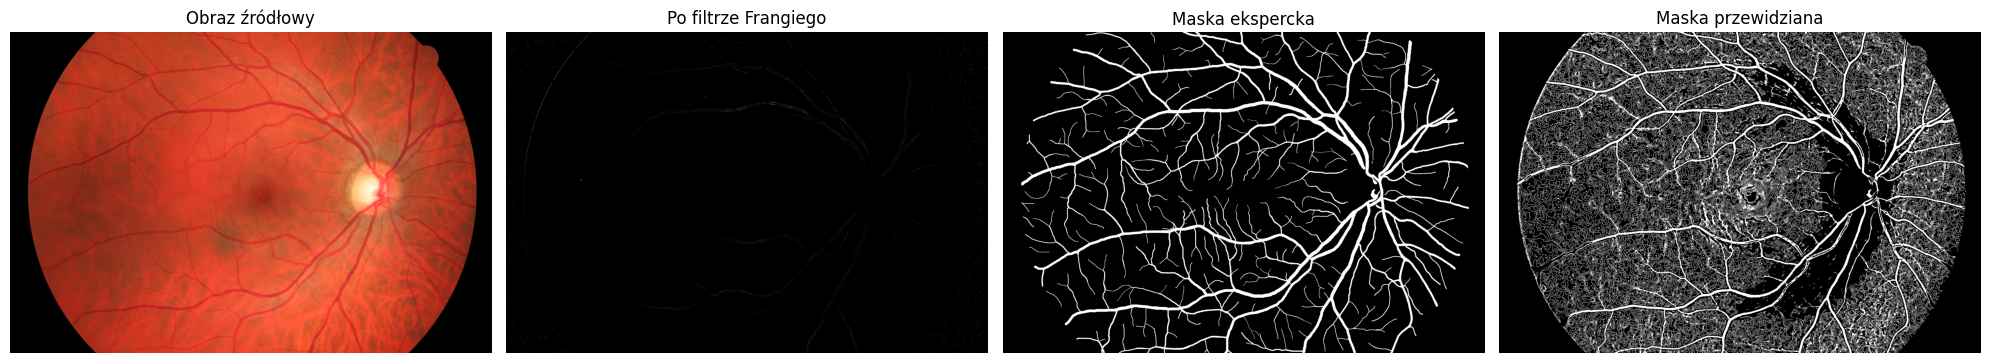

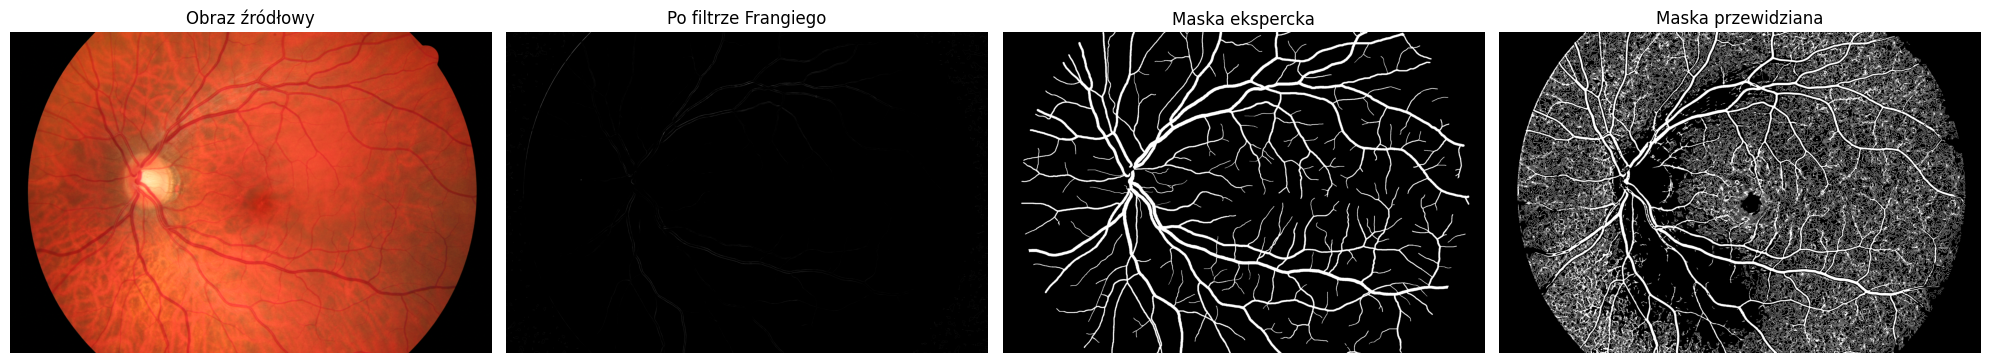

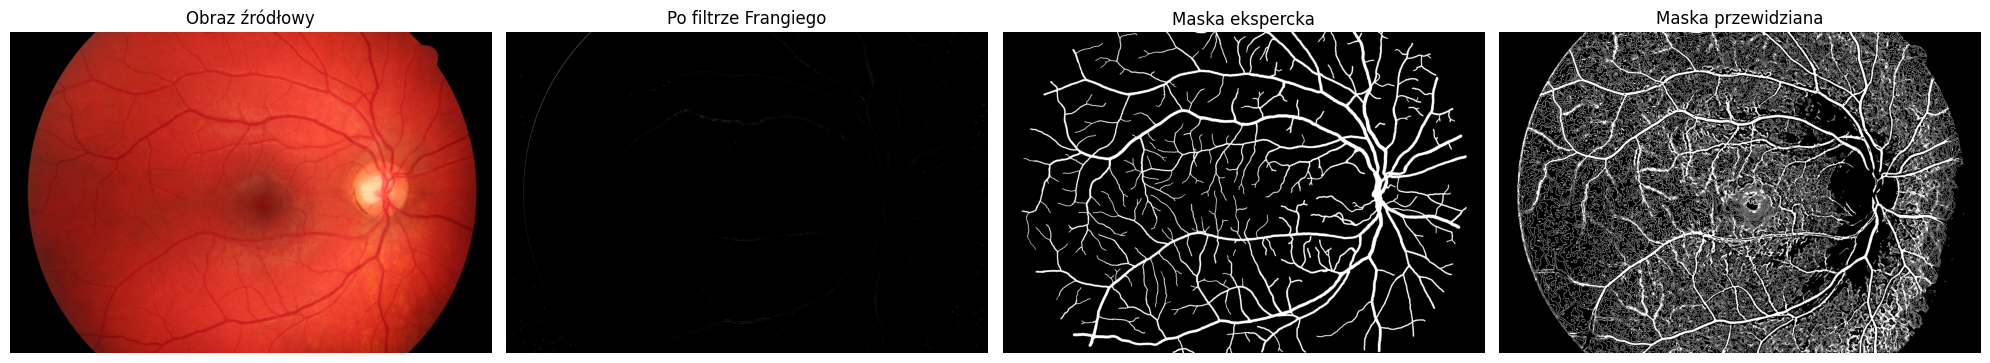

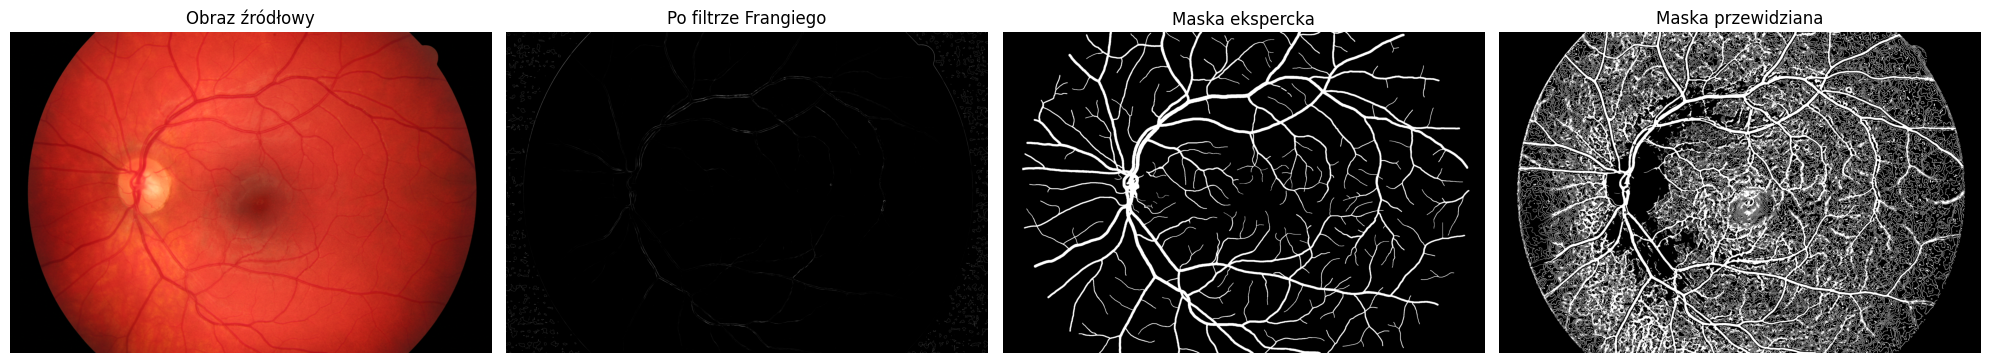

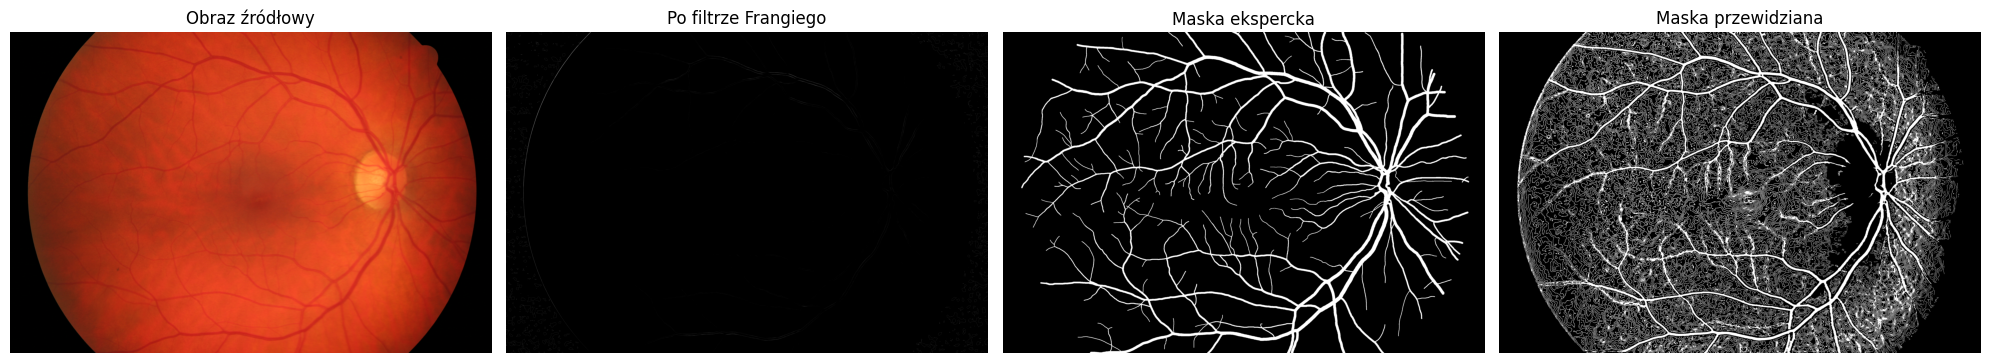

accuracy  sensitivity  specificity  harmonic_mean  arithmetic_mean  \
0  0.756950     0.666081     0.769413       0.714027         0.717747   
1  0.757356     0.713110     0.763215       0.737312         0.738162   
2  0.744673     0.650118     0.758183       0.700004         0.704151   
3  0.694191     0.788503     0.682342       0.731591         0.735423   
4  0.757828     0.681004     0.767022       0.721458         0.724013   

                                               image  
0  C:\Users\kamie\Projekty\Medycyna\DnoOka\health...  
1  C:\Users\kamie\Projekty\Medycyna\DnoOka\health...  
2  C:\Users\kamie\Projekty\Medycyna\DnoOka\health...  
3  C:\Users\kamie\Projekty\Medycyna\DnoOka\health...  
4  C:\Users\kamie\Projekty\Medycyna\DnoOka\health...

### Random Forest

In [81]:
def get_segments(image, patch_size=15):
    segments = []
    h, w = image.shape[:2]
    h = h - h % patch_size
    w = w - w % patch_size
    for y in range(0, h, patch_size):
        for x in range(0, w, patch_size):
            segment = image[y:y + patch_size, x:x + patch_size]
            segments.append(segment)
    return segments

def get_segment_stats(segment):
    gray_segment = cv2.cvtColor(segment, cv2.COLOR_BGR2GRAY)
    moments = cv2.moments(gray_segment)
    hu = cv2.HuMoments(moments).flatten()
    hu = -np.sign(hu) * np.log10(np.abs(hu) + 1e-10)

    r_var = np.var(segment[:, :, 2])
    g_var = np.var(segment[:, :, 1])
    b_var = np.var(segment[:, :, 0])

    return np.concatenate((hu, [r_var, g_var, b_var]))

def prepare_data(image_path, mask_path, patch_size=15):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    segments = get_segments(image, patch_size)
    mask_segments = get_segments(mask, patch_size)

    features = []
    labels = []

    for seg, msk in zip(segments, mask_segments):
        label = 1 if msk[patch_size//2, patch_size//2] > 0 else 0
        feat = get_segment_stats(seg)
        features.append(feat)
        labels.append(label)

    return np.array(features, dtype=np.float32), np.array(labels, dtype=np.uint8)



In [91]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import pandas as pd

# Trening: obraz 01
X, y = prepare_data("all/images/01_dr.jpg", "all/manual1/01_dr.tif", patch_size=15)

rus = RandomUnderSampler(random_state=42)
X_bal, y_bal = rus.fit_resample(X, y)

clf = DecisionTreeClassifier(max_depth=30, min_samples_leaf=5, random_state=42)

clf.fit(X_bal, y_bal)



DecisionTreeClassifier(max_depth=30, min_samples_leaf=5, random_state=42)

In [88]:
def classify_segments_with_threshold(image_path, clf, threshold=0.01, patch_size=15):
    image = cv2.imread(image_path)
    h, w = image.shape[:2]
    h = h - h % patch_size
    w = w - w % patch_size
    image = image[:h, :w]

    mask = np.zeros((h, w), dtype=np.uint8)
    vessel_count = 0

    for y in range(0, h, patch_size):
        for x in range(0, w, patch_size):
            patch = image[y:y + patch_size, x:x + patch_size]
            features = get_segment_stats(patch).reshape(1, -1)
            proba = clf.predict_proba(features)[0][1]
            if proba > threshold:
                mask[y:y + patch_size, x:x + patch_size] = 255
                vessel_count += 1

    print("Segmentów wykrytych jako naczynia:", vessel_count)
    return mask


In [89]:
def visualize_classification_result(test_image_path, predicted_mask, expert_mask_path):
    original = cv2.imread(test_image_path)
    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    expert_mask = cv2.imread(expert_mask_path, cv2.IMREAD_GRAYSCALE) > 0
    predicted = predicted_mask > 0

    tp = np.logical_and(predicted, expert_mask)
    fp = np.logical_and(predicted, ~expert_mask)
    fn = np.logical_and(~predicted, expert_mask)

    diff_map = np.zeros((*predicted.shape, 3), dtype=np.uint8)
    diff_map[tp] = [0, 255, 0]
    diff_map[fp] = [255, 0, 0]
    diff_map[fn] = [0, 0, 255]

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow(original)
    axs[0].set_title("Obraz źródłowy")

    axs[1].imshow(expert_mask, cmap='gray')
    axs[1].set_title("Maska ekspercka")

    axs[2].imshow(predicted, cmap='gray')
    axs[2].set_title("Maska RF (proba > threshold)")

    axs[3].imshow(diff_map)
    axs[3].set_title("TP/FP/FN (zielony/czerwony/niebieski)")

    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Segmentów wykrytych jako naczynia: 11229
   accuracy  sensitivity  specificity  harmonic_mean  arithmetic_mean      tp  \
0   0.72236     0.760519     0.719761       0.739578          0.74014  396898   

        fp      fn       tn  
0  2147600  124980  5515866  


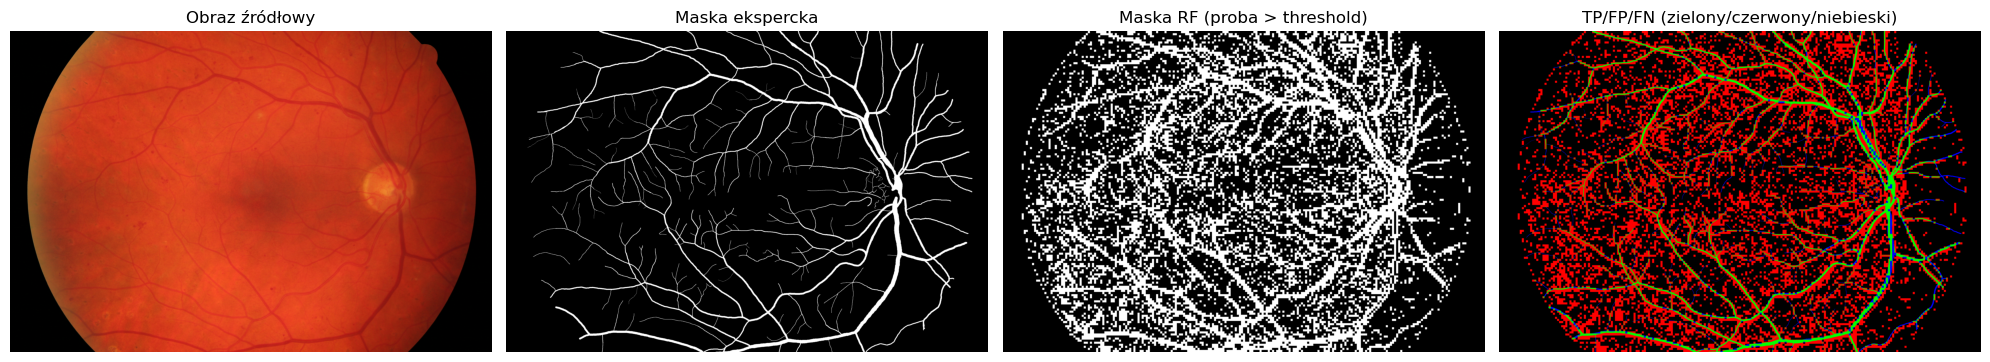

In [96]:
# Predykcja na obrazie 02
predicted_mask = classify_segments_with_threshold("all/images/02_dr.jpg", clf, patch_size=15, threshold=0.3)

# Załaduj GT maskę i oblicz metryki
gt_mask = cv2.imread("all/manual1/02_dr.tif", cv2.IMREAD_GRAYSCALE) > 0
if predicted_mask.shape != gt_mask.shape:
    predicted_mask = cv2.resize(predicted_mask, (gt_mask.shape[1], gt_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

y_pred = predicted_mask.flatten() > 0
y_true = gt_mask.flatten() > 0

metrics = compute_metrics(y_true.astype(int), y_pred.astype(int))
print(pd.DataFrame([metrics]))

# Wizualizacja
visualize_classification_result("all/images/02_dr.jpg", predicted_mask, "all/manual1/02_dr.tif")
